## Denoising Autoencoders

### Training a Denoising Autoencoder on Synthetic Gravitational Wave Data

In this section, we will use the synthetic gravitational wave (GW) data generation code from **Lecture 6** to train a **denoising autoencoder**. The goal is to reconstruct clean gravitational wave signals from noisy strain data.

The dataset consists of:
- **Injected signals**: Strain data with simulated GW signals embedded in white Gaussian noise.
- **Clean signals**: The underlying noise-free gravitational waveforms used for training targets.
- **Noise-only samples**: Strain data without any GW signal, included to help the autoencoder learn the background noise distribution.

We will use the clean signals as targets and the injected noisy signals as inputs to train the model. This autoencoder will learn a mapping from noisy inputs to clean outputs, effectively suppressing the noise while preserving the signal structure.

This approach mimics a realistic setting where the detector strain is corrupted by noise, and we aim to recover the astrophysical signal.

In [1]:
import os
import numpy as np
from tqdm.auto import tqdm

# Constants
G = 6.67430e-11  # m^3 / kg / s^2
c = 299792458    # m/s
M_sun = 1.98847e30  # kg
parsec = 3.085677581491367e16  # meters
Mpc = 1e6 * parsec

def simulate_gw_inspiral(m1_solar=30, m2_solar=30, DL_Mpc=400,
                         duration=2.0, fs=4096, inclination=0.0,
                         tc=None, phi_c=0.0, taper=True):
    """
    Simulate a realistic inspiral gravitational wave strain (h_plus only).

    Parameters:
    - m1_solar, m2_solar: Masses of binary components in solar masses
    - DL_Mpc: Luminosity distance in Megaparsecs
    - duration: Duration of the signal in seconds
    - fs: Sampling frequency in Hz
    - inclination: Inclination angle in radians (0 = face-on)
    - tc: Coalescence time (defaults to duration)
    - phi_c: Coalescence phase offset
    - taper: If True, zeroes the signal after coalescence

    Returns:
    - t: Time array
    - h_plus: Simulated GW strain (plus polarization)
    """
    # Convert units
    m1 = m1_solar * M_sun
    m2 = m2_solar * M_sun
    DL = DL_Mpc * Mpc
    M = m1 + m2
    eta = (m1 * m2) / M**2
    Mc = M * eta**(3/5)  # chirp mass
    Mc_sec = G * Mc / c**3  # chirp mass in seconds

    # Time array
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    dt = t[1] - t[0]

    # Coalescence time
    if tc is None:
        tc = duration

    # Time to coalescence
    tau = tc - t
    tau[tau <= 0] = 1e-6  # prevent division by zero

    # Frequency evolution
    f = (1 / (8 * np.pi * Mc_sec)) * (5 * Mc_sec / tau)**(3/8)

    # Phase evolution
    phi = 2 * np.pi * np.cumsum(f) * dt + phi_c

    # Amplitude evolution
    amp = (Mc_sec**(5/3)) * (np.pi * f)**(2/3)

    # Polarization factors
    F_plus = (1 + np.cos(inclination)**2)

    # Final waveform (plus polarization only)
    h_plus = (4 * amp * F_plus / DL) * np.cos(phi)

    # Taper after coalescence
    if taper:
        h_plus[t >= tc] = 0

    return t, h_plus

def generate_white_noise(duration=2.0, fs=4096, amplitude=1e-21):
    """
    Generate white Gaussian noise for a given duration and sampling rate.

    Parameters:
    - duration: Time duration of the noise signal (seconds)
    - fs: Sampling frequency (Hz)
    - amplitude: Standard deviation of the white noise

    Returns:
    - t: Time array
    - noise: White noise array
    """
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    noise = np.random.normal(0, amplitude, size=t.shape)
    return t, noise

def inject_signal_with_snr(signal, noise, target_snr):
    """
    Scale and inject a signal into noise to achieve a desired SNR.

    Parameters:
    - signal: Numpy array of the clean signal
    - noise: Numpy array of white noise
    - target_snr: Desired signal-to-noise ratio (scalar)

    Returns:
    - scaled_signal: The signal scaled to achieve the desired SNR
    - injected: signal + noise
    - actual_snr: Achieved SNR after scaling
    """
    assert len(signal) == len(noise), "Signal and noise must have same length"

    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)

    if signal_power == 0:
        raise ValueError("Signal power is zero; can't scale for SNR.")

    # Compute scaling factor
    scale = (target_snr * np.sqrt(noise_power)) / np.sqrt(signal_power)
    scaled_signal = signal * scale
    injected = scaled_signal + noise

    # Compute actual SNR
    actual_snr = np.sqrt(np.mean(scaled_signal**2) / noise_power)
    return scaled_signal, injected, actual_snr

def generate_noisy_dataset(
    num_samples=1000,
    snr_range=(0.1, 3.0),
    mass_range=(5, 80),
    distance_range=(100, 2000),
    fs=4096,
    duration=2.0,
    noise_amplitude=1e-21,
    save_path=None,
    seed=None
):
    """
    Generate a noisy dataset for ML with GW signals and pure noise.

    Returns:
    - injected_signals: [N, T] array of injected signals + noise
    - clean_signals: [N, T] array of clean GW signals (zero if noise-only)
    - labels: [N] array of binary labels (1 = signal, 0 = noise)
    """
    if seed is not None:
        np.random.seed(seed)

    N = num_samples
    T = int(fs * duration)
    injected_signals = np.zeros((N, T))
    clean_signals = np.zeros((N, T))
    labels = np.zeros(N)

    half_N = N // 2

    # Signal + noise
    for i in tqdm(range(half_N)):
        m1 = np.random.uniform(*mass_range)
        m2 = np.random.uniform(*mass_range)
        DL = np.random.uniform(*distance_range)
        inclination = np.random.uniform(0, np.pi)
        snr_target = np.random.uniform(*snr_range)

        t, h = simulate_gw_inspiral(m1, m2, DL, duration, fs, inclination)
        _, noise = generate_white_noise(duration, fs, amplitude=noise_amplitude)
        scaled_h, injected, _ = inject_signal_with_snr(h, noise, snr_target)

        injected_signals[i] = injected
        clean_signals[i] = scaled_h
        labels[i] = 1

    # Noise only
    for i in tqdm(range(half_N, N)):
        _, noise = generate_white_noise(duration, fs, amplitude=noise_amplitude)
        injected_signals[i] = noise
        clean_signals[i] = 0  # or leave as already zero
        labels[i] = 0

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        np.save(os.path.join(save_path, "injected_signals.npy"), injected_signals)
        np.save(os.path.join(save_path, "clean_signals.npy"), clean_signals)
        np.save(os.path.join(save_path, "labels.npy"), labels)

    return injected_signals, clean_signals, labels

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Sample 7748: Label = 1.0 (1 = signal)


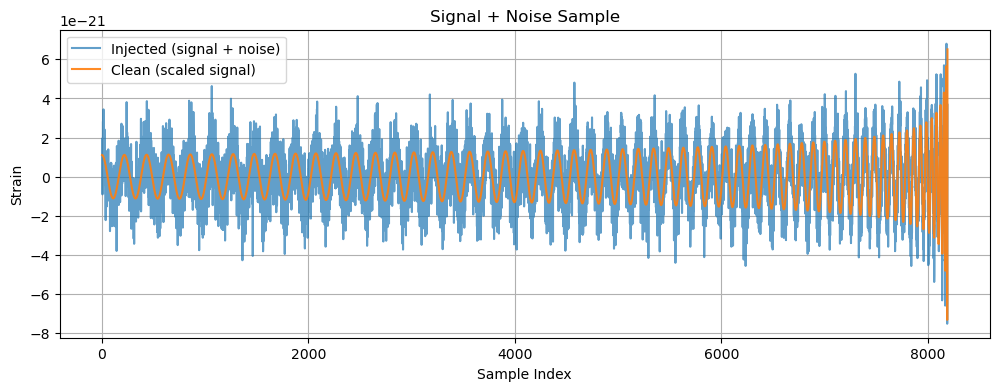

In [2]:
import matplotlib.pyplot as plt

num_events = 20000

# Generate dataset with 4 samples (2 signal+noise, 2 pure noise)
injected, clean, labels = generate_noisy_dataset(
    num_samples=num_events,
    snr_range=(1.0, 2.0),        # moderate SNR
    mass_range=(20, 40),         # typical BBH
    distance_range=(300, 600),   # Mpc
    fs=4096,
    duration=2.0,
    noise_amplitude=1e-21,
    seed=42                      # reproducibility
)

# Inspect sample 0 (should be signal+noise)
i = np.random.choice(num_events)
print(f"Sample {i}: Label = {labels[i]} (1 = signal)")
plt.figure(figsize=(12, 4))
plt.plot(injected[i], label="Injected (signal + noise)", alpha=0.7)
plt.plot(clean[i], label="Clean (scaled signal)", alpha=0.9)
plt.title("Signal + Noise Sample")
plt.xlabel("Sample Index")
plt.ylabel("Strain")
plt.legend()
plt.grid()
plt.show()

# Let's code a Conv1D auto-encoder

In [28]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_dims=[64, 32, 2], kernel_size=3):
        super().__init__()
        layers = []
        for i, h_dim in enumerate(hidden_dims):
            layers.append(nn.Conv1d(
                in_channels if i == 0 else hidden_dims[i-1],
                h_dim,
                kernel_size=kernel_size,
                stride=2,
                padding=kernel_size // 2
            ))
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, out_channels=1, hidden_dims=[2, 32, 64], kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.ConvTranspose1d(
                hidden_dims[i],
                hidden_dims[i+1],
                kernel_size=kernel_size,
                stride=2,
                padding=kernel_size // 2,
                output_padding=1
            ))
            layers.append(nn.ReLU())
        layers.append(nn.ConvTranspose1d(
            hidden_dims[-1],
            out_channels,
            kernel_size=kernel_size,
            stride=2,
            padding=kernel_size // 2,
            output_padding=1
        ))
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)
    
class AutoEncoder(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels)
        self.decoder = Decoder(out_channels=in_channels)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# -----------------------------------------------------
# Step 1: Convert to torch tensors
# Shape: [N, T] => add channel dimension to make it [N, 1, T] for Conv1d
# -----------------------------------------------------
injected_tensor = torch.tensor(injected[:num_events//2]*1e21, dtype=torch.float32).unsqueeze(1)
clean_tensor = torch.tensor(clean[:num_events//2]*1e21, dtype=torch.float32).unsqueeze(1)
labels_tensor = torch.tensor(labels[:num_events//2], dtype=torch.long)

# -----------------------------------------------------
# Step 3: Split into train/test sets (80/20)
# -----------------------------------------------------
x_train, x_test, clean_train, clean_test, y_train, y_test = train_test_split(
    injected_tensor, clean_tensor, labels_tensor,
    test_size=0.2,
    random_state=42,
    stratify=labels_tensor  # preserve class balance
)

# ------------------------
# DataLoaders
# ------------------------
batch_size = 64
train_loader = DataLoader(TensorDataset(x_train, clean_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, clean_test), batch_size=batch_size)

# -----------------------------------------------------
# Choose device
# -----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------------------------------
# Step 4: Define the denosing model
# -----------------------------------------------------
model = AutoEncoder(in_channels=1).to(device)

# -----------------------------------------------------
# Step 5: Define loss and optimizer
# -----------------------------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# -----------------------------------------------------
# Step 6: Training loop
# -----------------------------------------------------
epochs = 10
loss_vals = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for noisy_input, clean_target in train_loader:
        noisy_input = noisy_input.to(device)
        clean_target = clean_target.to(device)

        output = model(noisy_input)
        loss = criterion(output, clean_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_vals.append(avg_loss)
    print(f"Epoch {epoch+1:2d} | Train Loss: {avg_loss:.6f}")

Using device: cuda
Epoch  1 | Train Loss: 2.135243
Epoch  2 | Train Loss: 1.026770
Epoch  3 | Train Loss: 0.734947
Epoch  4 | Train Loss: 0.386474
Epoch  5 | Train Loss: 0.137600
Epoch  6 | Train Loss: 0.118504
Epoch  7 | Train Loss: 0.109484
Epoch  8 | Train Loss: 0.100502
Epoch  9 | Train Loss: 0.092648
Epoch 10 | Train Loss: 0.086965


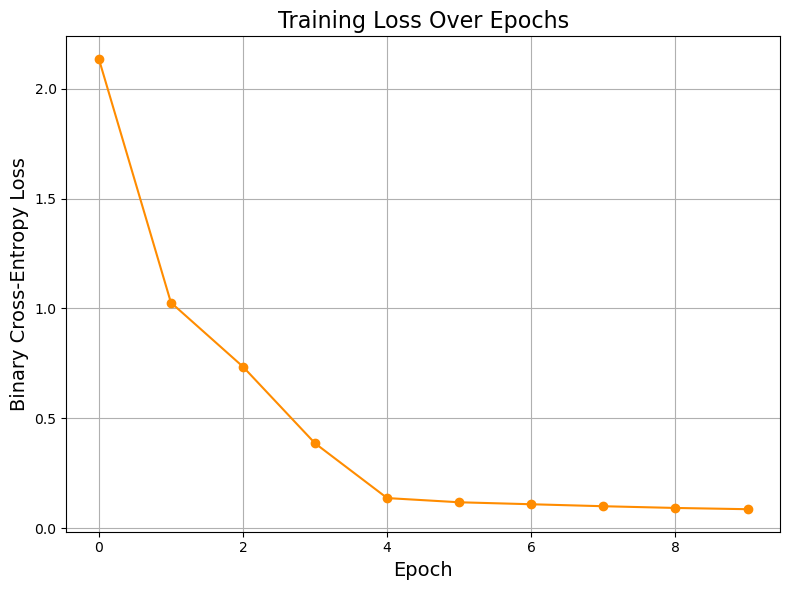

In [30]:
# ---------------------------------------
# 6. Visualize the loss curve
# ---------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(loss_vals, 'o-', color='darkorange')
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Binary Cross-Entropy Loss", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

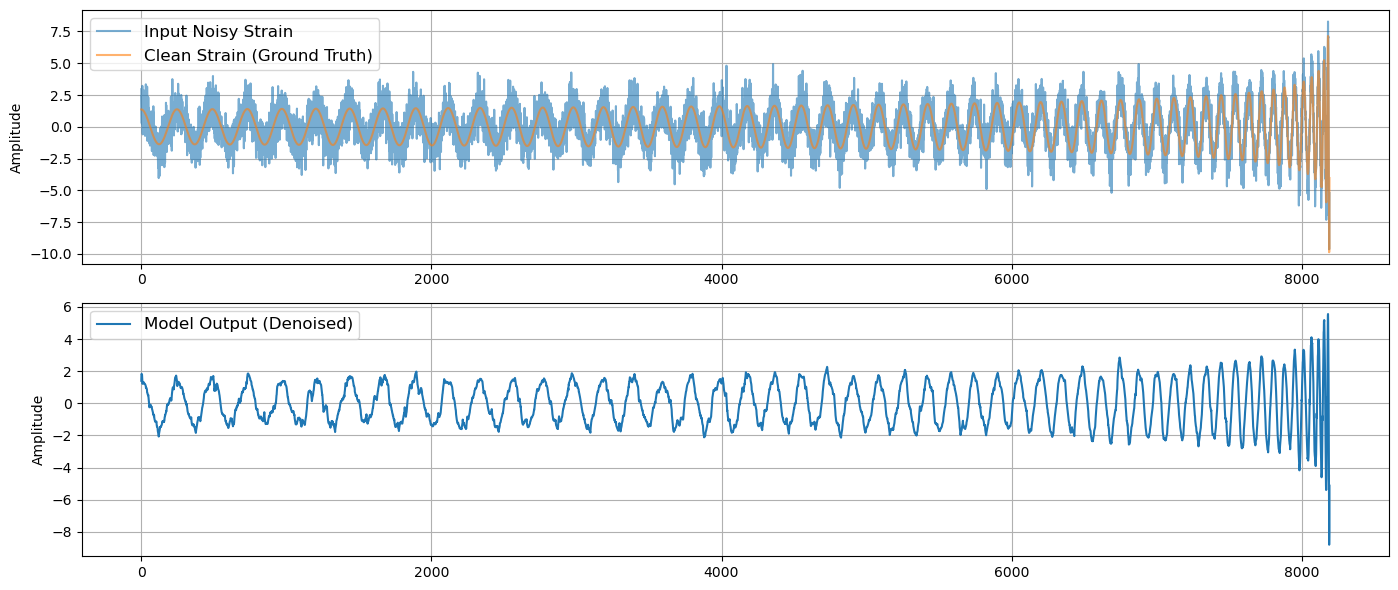

In [55]:
import matplotlib.pyplot as plt

# Make sure model is in eval mode
model.eval()

# Pick one batch from test_loader
with torch.no_grad():
    for noisy_input, clean_target in test_loader:
        noisy_input = noisy_input.to(device)
        clean_target = clean_target.to(device)
        output = model(noisy_input)
        break  # Only take the first batch

# Convert to CPU and squeeze [B, 1, T] → [T]
idx = 0  # pick first sample in batch
input_signal = noisy_input[idx].cpu().squeeze().numpy()
clean_signal = clean_target[idx].cpu().squeeze().numpy()
output_signal = output[idx].cpu().squeeze().numpy()

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(input_signal, alpha=0.6, label="Input Noisy Strain")
plt.plot(clean_signal, alpha=0.6, label="Clean Strain (Ground Truth)")
plt.ylabel("Amplitude")
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(output_signal, label="Model Output (Denoised)")
plt.legend(fontsize=12)
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()
